<a href="https://colab.research.google.com/github/omkarade/Recommendation-System-Using-Deep-Learning/blob/main/Recommendation_System_Using_Deep%C2%A0Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Embedding
from keras.layers import Add, Activation, Lambda
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
from transformers import AutoTokenizer


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
PATH = 'ml-latest-small/'
ratings = pd.read_csv(PATH + 'ratings.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


**marging dataset**

In [ ]:
ratings = pd.merge(ratings, movies[['genres','movieId']], on="movieId")

In [ ]:
movies = pd.read_csv(PATH + 'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


**some preprocessing**

In [ ]:
movies['genres']=movies.genres.str.replace('Sci-Fi','science fiction')
movies['genres']=movies.genres.str.replace('|',' ')

**converting genres into bert 1X1 vector**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
new=[]
for i in movies['genres'].values:
  gen1=tokenizer(i)
  gen2=gen1['input_ids']
  gen2.pop(0)
  gen2.pop(-1)
  new.append(sum(gen2))
movies['genres_token']=new

In [ ]:
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]
g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]
top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)


movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


In [ ]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])
n_users, n_movies, min_rating, max_rating


(610, 9724, 0.5, 5.0)

In [ ]:
X = ratings[['user', 'movie','genres_token']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#Embeddings 50 dim
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1],X_train[:, 2]]
X_test_array = [X_test[:, 0], X_test[:, 1],X_test[:, 2]]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 3), (10084, 3), (90752,), (10084,))

**Building Model**

In [ ]:
from keras.layers import Add, Activation, Lambda
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [ ]:
from keras.layers import Concatenate, Dense, Dropout
def RecommenderNet(n_users,n_movies,gen,n_factors, min_rating, max_rating):
    
    user = Input(shape=(1,),name='user')
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,),name='movie')
    m = EmbeddingLayer(n_movies, n_factors)(movie)

    genres = Input(shape=(1,),name='genres')
    g = EmbeddingLayer(gen,n_factors)(genres)

    n = Dot(axes=1)([m,g])


    x = Concatenate()([u,n])


    x = Dense(72, kernel_initializer='he_normal')(x)
    x = Activation('LeakyReLU')(x)
    x = Dropout(0.5)(x)

    

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user,movie,genres], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model


In [ ]:
model = RecommenderNet(n_users,n_movies,gen,n_factors, min_rating, max_rating)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 genres (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 embedding_31 (Embedding)       (None, 1, 50)        486200      ['movie[0][0]']                  
                                                                                            

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=32, epochs=15,verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/15
2836/2836 [==============================] - 23s 8ms/step - loss: 0.8326 - val_loss: 0.7372
Epoch 2/15
2836/2836 [==============================] - 20s 7ms/step - loss: 0.7250 - val_loss: 0.7199
Epoch 3/15
2836/2836 [==============================] - 21s 7ms/step - loss: 0.6934 - val_loss: 0.7198
Epoch 4/15
2836/2836 [==============================] - 21s 8ms/step - loss: 0.6787 - val_loss: 0.7193
Epoch 5/15
2836/2836 [==============================] - 21s 7ms/step - loss: 0.6666 - val_loss: 0.7174
Epoch 6/15
2836/2836 [==============================] - 21s 8ms/step - loss: 0.6615 - val_loss: 0.7266
Epoch 7/15
2836/2836 [==============================] - 24s 9ms/step - loss: 0.6563 - val_loss: 0.7211
Epoch 8/15
2836/2836 [==============================] - 21s 7ms/step - loss: 0.6529 - val_loss: 0.7245
Epoch 9/15
2836/2836 [==============================] - 22s 8ms/step - loss: 0.6491 - val_loss: 0.7191
Epoch 10/15
2836/2836 [==============================] - 21s 8ms/step - l

**after 15 epoch lowest val loss is 0.71**

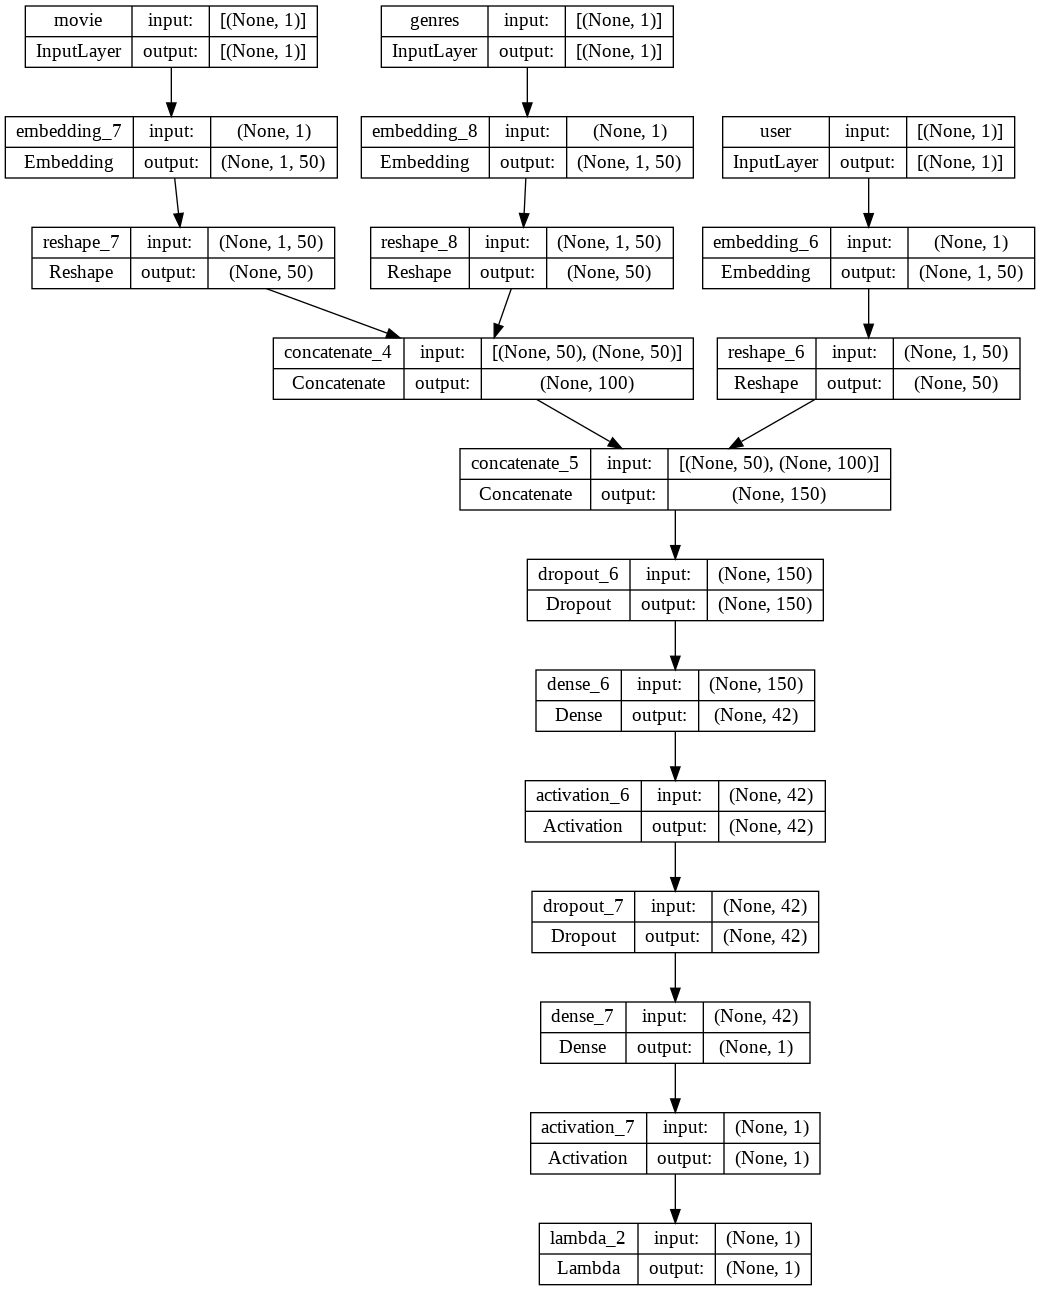

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)  